Convert all ipynb files in repository in py files
jupyter nbconvert --to script *.ipynb

In [1]:
# !pip install hurst
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import time
import warnings
import threading
import gc
from hurst import compute_Hc
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# import torch.nn as nn
# import torch
# from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

In [ ]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [2]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [3]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
train.head(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [4]:
# dataframe dimensiosn
print(train.shape)

def pl_replace(df, replace_dict):
    return df.with_columns(pl.all().replace(replace_dict))

# For eeg data
def loadeeg(path):
    eeg = pl.read_parquet(path)
    # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    eeg = eeg.fill_null(0)
    eeg = eeg.fill_nan(0)
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pl.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    return (row,spectrogram,time)


(106800, 15)


# Compute time domain features

In [5]:
# Initialise a few things
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

train_grby = train.groupby("eeg_id")

(18000, 20)


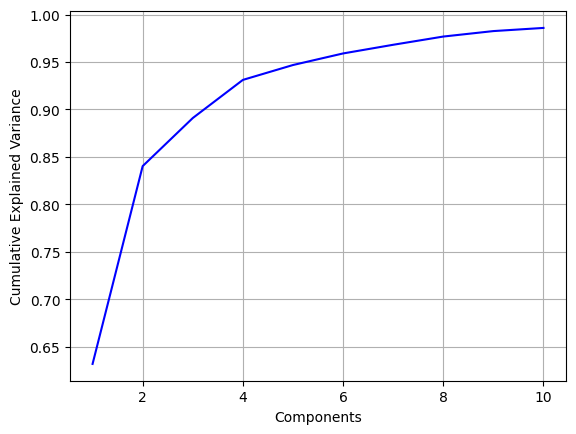

In [6]:
i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
print(fulleeg.shape)

n_comp = 10
pca = PCA(n_comp)
pcafit = pca.fit_transform(fulleeg)

pca.explained_variance_ratio_
ev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,n_comp+1),ev, "b-")
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()
plt.close()

# selection 8 components for ~97.5% of the explained variance

In [6]:
def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out

In [7]:
class cThreadParams():
    def __init__(self):
        threading.Thread.__init__(self)
        self.next = 0
        self.n_comp = 8
        self.pca = PCA(self.n_comp)
        self.PCA_columns = pd.Series(range(0,self.n_comp)).apply(lambda x: 'pca' + str(x)).to_list()

def run_file_opener(thread):
    file_id = train.eeg_id.unique()[min(count+1,17088)]
    path = f'{EEG_PATH}{file_id}.parquet'
    thread.next = loadeeg(path)
    thread.next = pl.DataFrame(thread.pca.fit_transform(thread.next))
    thread.next.columns = thread.PCA_columns
    thread.next = thread.next.with_row_index(offset = 0)
    thread.continue_ = False

In [8]:
segment_col = np.zeros(len(time_eeg))
mask = time_eeg < -5
print(pd.Series(mask).value_counts())
segment_col[mask] = -1
mask = time_eeg > 5
print(pd.Series(mask).value_counts())
segment_col[mask] = 1

False    6000
True     4001
Name: count, dtype: int64
False    6001
True     4000
Name: count, dtype: int64


In [9]:
channels_id = pd.Series(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
segment_names = {-1:"_before",0:"_during",1:"_after"}
var = ['eeg_label_offset_seconds']

# I add the names of the columns here to not calculate it within the for loop. 
colnames = ['pca0_mean', 'pca0_std', 'pca0_kurt', 'pca0_skew', 'pca0_rng', 'pca0_linelength', 'pca0_rms', 'pca0_hurst', 'pca1_mean', 'pca1_std',
            'pca1_kurt', 'pca1_skew', 'pca1_rng', 'pca1_linelength', 'pca1_rms', 'pca1_hurst', 'pca2_mean', 'pca2_std', 'pca2_kurt', 'pca2_skew',
            'pca2_rng', 'pca2_linelength', 'pca2_rms', 'pca2_hurst', 'pca3_mean', 'pca3_std', 'pca3_kurt', 'pca3_skew', 'pca3_rng', 'pca3_linelength',
            'pca3_rms', 'pca3_hurst', 'pca4_mean', 'pca4_std', 'pca4_kurt', 'pca4_skew', 'pca4_rng', 'pca4_linelength', 'pca4_rms', 'pca4_hurst',
            'pca5_mean', 'pca5_std', 'pca5_kurt', 'pca5_skew', 'pca5_rng', 'pca5_linelength', 'pca5_rms', 'pca5_hurst', 'pca6_mean', 'pca6_std',
            'pca6_kurt', 'pca6_skew', 'pca6_rng', 'pca6_linelength', 'pca6_rms', 'pca6_hurst', 'pca7_mean', 'pca7_std', 'pca7_kurt', 'pca7_skew',
            'pca7_rng', 'pca7_linelength', 'pca7_rms', 'pca7_hurst', 'segments']


n_parquet = 170 # 0:170 is ~1% of the dataset
mask = train.eeg_id.isin(train.eeg_id.unique()[0:n_parquet])
TD_Features_wf = train.loc[mask, ['eeg_id']].copy()
TD_Features_lf = pl.DataFrame()

# polars functions with columns, and makes it harder to replace values of a single row. It requires to always change the entire column, 
# and the python code to do so is heavy. To avoid it, I have created a predefined numpy array called "segment_col" with the values of 
# the "segments" column (-1,0,1). For each eeg dataset, I will simply add a new column containing all the predefined numpy values. 
segment_col = np.zeros(len(time_eeg))
mask = time_eeg < -5
segment_col[mask] = -1
mask = time_eeg > 5
segment_col[mask] = 1

t = time.time()

params = cThreadParams()


count = -1
thr = threading.Thread(target=run_file_opener, args=(params,))
thr.start()
time.sleep(2)

fail = {}

for count, id in enumerate(train.eeg_id.unique()[0:n_parquet]):
    # if count%10 == 0: print(count)
    
    thr.join()
    pcaeeg = params.next.clone()
    print(count, pcaeeg.shape)

    thr = threading.Thread(target=run_file_opener, args=(params,))
    thr.start()
    
    for i, offset in train_grby.get_group(id)[var].itertuples():

        eeg = pcaeeg.filter((pl.col("index") >= offset*200) & (pl.col("index") <= (offset+50)*200)).clone()
        
        if eeg.shape[0] >9999:
            
            eeg = eeg.with_columns(pl.Series("segments", segment_col[0:eeg.shape[0]]))
            eeg_by_seg = eeg.group_by('segments')
    
            features = eeg_by_seg.agg(pl.exclude("index").mean().name.suffix("_mean"),
                              pl.exclude("index").std().name.suffix("_std"),
                              pl.exclude("index").kurtosis().name.suffix("_kurt"),
                              pl.exclude("index").skew().name.suffix("_skew"),
                              (pl.exclude("index").max()-pl.exclude("row_nr").min()).name.suffix("_rng"),
                              pl.exclude("index").diff().abs().sum().name.suffix("_linelength"),
                              pl.exclude("index").pow(2).mean().pow(0.5).name.suffix("_rms"),
                              pl.exclude("index").apply(lambda x: hurst_fct(x)).name.suffix("_hurst"))

            TD_Features_lf = pl.concat([TD_Features_lf, features])

        else: 
            if id not in fail.keys():
                fail[id] = []
            fail[id].append(offset)
            print(count, id, eeg.shape, offset)

thr.join()

TD_Features_wf = pl.DataFrame()

for i in [-1,0,1]:
    colnames = pl.Series(TD_Features_lf.columns) + segment_names[i]
    copyTDF_lf = TD_Features_lf.clone().filter(pl.col('segments') == i)
    copyTDF_lf.columns = colnames
    TD_Features_wf = pl.concat([TD_Features_wf, copyTDF_lf], how = "horizontal")

TD_Features_wf = TD_Features_wf.drop(["segments_before", "segments_during", "segments_after"])

print(f"Running time: {time.time()-t} s")


# Note 1: the version with pandas runs in 1730.8s for 173 parquet files (1% of all) and 5174 rows (1.6% of all) in 1730.8s

# Note 2: filling the wide format dataframe outside of the loop saves 1.8 s per 17 parquet files and/or per 200 lines.

# Note 3: I encountered an error between trials 60 and 70 for the compute_Hc function, hence the use of hurst_fct.
#        The error message is: invalid value encountered in double_scalars

# Note 4: the version with polars runs in 1322.3s for 170 parquet files (1% of all) and 5153 rows (1.6% of all)

# Note 5: the version with polars and a thread to open the parquet files runs in 1000 s for 170 parquet files (1% of all) and 5153 rows (1.6% of all)
#         This means that for all parquet files, it should take approximately 5h45. It's a considerable improvement compared to the initial 400+ hours,
#         and compared to the pandas ~29h50 version and polars ~22h45 version
#         There are ~2640 parquet files in the hidden test data: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/471287
#         It means that the computation time for the test set should probably be between 52 min (considering the time per row and assuming ~16300 rows 
#         in the test set) and 4h15 (considering the time per parquet file). Let's keep in mind that this is only with time domain features. 
#         IMPORTANT: this method sometimes fail, but I don't understand the reason. The thread seems to die, the CPU usage drops, and the kernel does not work anymore.

0 (18000, 9)
1 (10400, 9)
2 (14800, 9)
3 (12400, 9)
4 (13600, 9)
5 (15600, 9)
6 (16000, 9)
7 (10000, 9)
8 (10400, 9)
9 (10800, 9)
10 (13600, 9)
11 (12800, 9)
12 (16400, 9)
13 (13600, 9)
14 (11600, 9)
15 (10000, 9)
16 (10000, 9)
17 (10000, 9)
18 (10000, 9)
19 (20400, 9)
20 (13200, 9)
21 (12400, 9)
22 (10000, 9)
23 (16000, 9)
24 (11200, 9)
25 (10000, 9)
26 (10000, 9)
27 (10400, 9)
28 (10000, 9)
29 (11200, 9)
30 (19200, 9)
31 (11200, 9)
32 (10000, 9)
33 (10000, 9)
34 (19600, 9)
35 (14800, 9)
36 (18800, 9)
37 (10000, 9)
38 (11200, 9)
39 (31200, 9)
40 (11200, 9)
41 (10400, 9)
42 (16000, 9)
43 (10000, 9)
44 (16000, 9)
45 (22000, 9)
46 (15600, 9)
47 (11600, 9)
48 (10800, 9)
49 (14800, 9)
50 (10000, 9)
51 (20400, 9)
52 (21200, 9)
53 (10000, 9)
54 (10000, 9)
55 (10000, 9)
56 (10400, 9)
57 (13600, 9)
58 (10000, 9)
59 (15200, 9)
60 (34400, 9)
61 (20800, 9)
62 (29200, 9)
63 (10000, 9)
64 (10400, 9)
65 (10000, 9)
66 (10000, 9)
67 (10800, 9)
68 (10000, 9)
69 (16400, 9)
70 (10000, 9)
71 (14800, 9)
72

In [ ]:
# SVD Entropy
# eeg_z = (eeg_seg-eeg_seg.mean())/eeg_seg.std()
#u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
# s = s/np.sum(s)
#TD_Features.loc[i, channels+"_SVDEn_"+ segment_names[seg]] = -(s*np.log(s)).sum()
# linelength['SVDEn' + seg] = SVDEn

# # Entropy
# add = eeg.sum()
# eegnorm = eeg/add
# entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
# entropy.index = entropy.index + '_entropy' + seg
# entropy = entropy.to_frame().transpose()

# Hurst Exponent
# hurst = []
#for idx,channel in enumerate(eeg.keys()):
#    h, c, data = compute_Hc(eeg[channel], simplified=True)
#    hurst.append(h)
# hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))

In [10]:
print(TD_Features_lf.shape)
print(TD_Features_wf.shape)

(5160, 65)
(1720, 192)


In [12]:
colnames = TD_Features_lf.columns
pandas_data = TD_Features_lf.to_numpy()
pandas_data = pd.DataFrame(pandas_data)
pandas_data.columns = colnames
pandas_data.tail()

,segments,pca0_mean,pca1_mean,pca2_mean,pca3_mean,pca4_mean,pca5_mean,pca6_mean,pca7_mean,pca0_std,...,pca6_rms,pca7_rms,pca0_hurst,pca1_hurst,pca2_hurst,pca3_hurst,pca4_hurst,pca5_hurst,pca6_hurst,pca7_hurst
5155,-1.0,-6274.368036,-263.451866,155.497369,98.504702,-24.025275,18.169432,24.807966,3.056516,170.026350,...,52.737263,46.702870,0.301606,0.509371,0.401679,0.503034,0.516309,0.447344,0.449144,0.412769
5156,1.0,-6253.733373,-305.354520,182.016621,90.629628,0.210340,-3.484972,2.967708,-3.529298,138.228829,...,45.089211,46.403903,0.261133,0.487685,0.297040,0.458009,0.477768,0.413193,0.397039,0.383628
5157,0.0,-45.067509,2.262829,0.701706,-0.259904,-2.369080,2.856226,0.166370,-1.024361,97.228348,...,21.344218,12.469003,0.395399,0.311690,0.332304,0.355437,0.350421,0.376234,0.314871,0.367966
5158,-1.0,9.733464,1.452658,3.471748,0.219061,-0.610242,0.096015,-0.752884,1.268007,93.704691,...,17.788298,15.369619,0.363481,0.238784,0.293315,0.305651,0.292473,0.303794,0.274251,0.272638
5159,1.0,12.801058,-2.585082,-3.824426,-0.089186,1.795383,-1.524533,0.670054,-0.756333,87.730522,...,20.813429,15.095004,0.341560,0.261327,0.277382,0.329270,0.286120,0.320976,0.295981,0.321221


In [13]:
pandas_data.segments.value_counts()

segments
 0.0    1720
-1.0    1720
 1.0    1720
Name: count, dtype: int64

In [15]:
TD_Features_wf.tail(20)

pca0_mean_before,pca1_mean_before,pca2_mean_before,pca3_mean_before,pca4_mean_before,pca5_mean_before,pca6_mean_before,pca7_mean_before,pca0_std_before,pca1_std_before,pca2_std_before,pca3_std_before,pca4_std_before,pca5_std_before,pca6_std_before,pca7_std_before,pca0_kurt_before,pca1_kurt_before,pca2_kurt_before,pca3_kurt_before,pca4_kurt_before,pca5_kurt_before,pca6_kurt_before,pca7_kurt_before,pca0_skew_before,pca1_skew_before,pca2_skew_before,pca3_skew_before,pca4_skew_before,pca5_skew_before,pca6_skew_before,pca7_skew_before,pca0_rng_before,pca1_rng_before,pca2_rng_before,pca3_rng_before,pca4_rng_before,…,pca3_skew_after,pca4_skew_after,pca5_skew_after,pca6_skew_after,pca7_skew_after,pca0_rng_after,pca1_rng_after,pca2_rng_after,pca3_rng_after,pca4_rng_after,pca5_rng_after,pca6_rng_after,pca7_rng_after,pca0_linelength_after,pca1_linelength_after,pca2_linelength_after,pca3_linelength_after,pca4_linelength_after,pca5_linelength_after,pca6_linelength_after,pca7_linelength_after,pca0_rms_after,pca1_rms_after,pca2_rms_after,pca3_rms_after,pca4_rms_after,pca5_rms_after,pca6_rms_after,pca7_rms_after,pca0_hurst_after,pca1_hurst_after,pca2_hurst_after,pca3_hurst_after,pca4_hurst_after,pca5_hurst_after,pca6_hurst_after,pca7_hurst_after
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.761386,-5.162273,0.91037,-0.104941,-0.152255,3.059999,-1.013268,0.890741,188.139981,171.661386,59.309318,41.809699,40.81054,35.937028,22.086747,17.346461,-0.398581,-0.063448,0.200611,0.764697,-0.217656,-0.129426,-0.229139,0.475832,0.476052,0.032625,0.380976,0.324266,0.223072,-0.098205,0.278248,0.210768,956.758397,1027.49156,403.894787,297.861598,234.266497,…,0.220948,-0.234513,-0.297855,0.2802,0.402637,984.450509,870.688864,468.86759,268.142295,218.070092,196.279868,155.941739,127.12018,90674.086343,93211.183602,58108.268623,15000.428019,25740.891206,24962.672184,14301.494122,10159.271333,154.888412,141.499204,78.150496,45.418465,39.958829,31.403263,20.431886,17.798914,0.418177,0.383088,0.355784,0.42224,0.374139,0.34955,0.375481,0.378647
37377.224503,-536.933673,6.971582,-11.758784,-0.522601,2.015754,0.207335,0.457256,1.959604,0.007737,0.011199,0.005182,0.000204,0.000028,0.00035,0.000039,-0.589537,-0.589537,-0.589537,-0.589537,-0.589537,-0.589537,-0.589537,-0.589537,-0.125019,0.125019,0.125019,0.125019,-0.125019,0.125019,-0.125019,0.125019,7.14686,0.028216,0.040845,0.0189,0.000742,…,0.426164,-1.064314,-0.138922,-0.357358,-0.071515,923.578641,763.58888,549.254861,474.532694,555.459314,386.034269,203.997935,239.417998,195664.53011,22825.000046,23942.092001,16174.031504,17717.449242,18796.149824,13891.466769,16593.80493,6128.128771,166.133017,159.715749,155.169213,109.696134,86.417417,40.250411,42.959872,0.279202,0.506852,0.524388,0.471631,0.422105,0.401891,0.386942,0.363324
37236.877298,-322.313949,128.235798,-29.28735,-0.377761,3.128816,-0.339627,0.241383,1724.351205,2482.912755,1462.224318,232.527288,22.1907,14.030768,23.469575,9.144781,278.885196,131.356309,136.656241,139.161197,2670.709455,254.629862,1501.346299,1890.704817,-14.770891,11.528345,11.704174,-9.635631,49.008122,14.707109,25.898473,32.549676,55056.499187,31257.549448,26124.669373,6836.056691,1426.316596,…,0.276969,-1.014049,-0.042182,-0.306759,-0.208582,923.578641,607.437357,353.114492,474.532694,638.463456,386.034269,203.997935,230.03303,194700.958819,23051.251403,23989.172083,16448.153748,18611.375122,19022.447956,13889.07206,16728.183708,6153.702272,150.370923,109.945625,142.642554,114.536753,85.393995,39.236663,41.663945,0.281989,0.465686,0.443839,0.465223,0.414109,0.39562,0.391539,0.362181
34211.041034,930.288975,-111.743745,66.666735,5.863013,-4.327478,0.532185,1.015569,9292.810647,4607.092758,2071.70841,816.466387,51.79519,32.579807,34.

In [ ]:
staticX2 = np.fft.fft(eeg['Fp1'])

staticHz = np.linspace(0,100,int(len(eeg['Fp1'])/2+1))

plt.plot(staticHz[1:],np.abs(staticX2[1:len(staticHz)]),'-.',label='FFT')
plt.show()

In [ ]:
# Explore what frequencies are in the spectrogram

allkeys = spectrogram.keys()
llkeys = []
for key in allkeys:
    if 'LL' in key:
        llkeys.append(key)
        
print(llkeys)

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(eeg['Fp1'].to_numpy(),fs = 200,noverlap=10)
plt.pcolormesh(t,f,Sxx,shading='gouraud',vmin=0,vmax=10)
plt.ylabel('Frequency (a.u.)')
plt.xlabel('Time (a.u.)')
# plt.ylim([0,.005])
plt.show()


In [ ]:
spect = spectrogram.to_numpy()
plt.imshow(spect,vmin= 0, vmax = 10)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(fulleeg)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])